### Import Packages

In [47]:
import os
import pandas as pd
from sqlalchemy import create_engine, exists
import pymysql

import matplotlib.pyplot as pl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle


### Cleaning data

#### Connect to database

In [48]:
# Read sensitive information from environment variables
api_key = os.getenv('OPENWEATHERMAP_API_KEY', "5b103a5aa9cd52cd178d63c3c83ad6ec")
db_username = os.getenv('DB_USERNAME', 'admin')
db_password = os.getenv('DB_PASSWORD', 'qwerty123')
db_name = os.getenv('DB_NAME', 'dublinbikes')
db_endpoint = os.getenv('DB_ENDPOINT', 'dublinbikes.ch2g8eocy1o4.eu-west-1.rds.amazonaws.com')
db_port = os.getenv('DB_PORT', '3306')


# Construct the database connection URL, using pymysql as the driver for the MySQL database
database_url = f"mysql+pymysql://{db_username}:{db_password}@{db_endpoint}:{db_port}/{db_name}"

# Attempt to create the database engine and connect
try:
    db = create_engine(database_url)
    conn = db.connect()
    print("Connected to the database successfully.")

except Exception as e:
    print(f"An error occurred: {e}")

Connected to the database successfully.


#### Get data

In [50]:
# withdraw data
query_station = "SELECT * FROM station"
query_availability = "SELECT * FROM availability"
query_weather = "SELECT * FROM weather"

df_station = pd.read_sql_query(query_station, db)
df_availability = pd.read_sql_query(query_availability, db)
df_weather = pd.read_sql_query(query_weather, db)

#### Weather Table

In [51]:
# 1. check data
print(df_weather.head())
print(df_weather.info())
print(df_weather.describe())

# 2. clean data
# only save columns we need
columns_to_keep = ['weather_main', 'weather_description', 'temperature', 'feels_like', 'pressure', 'humidity', 'visibility', 'wind_speed', 'wind_deg', 'clouds_all', 'last_update']
df_weather = df_weather[columns_to_keep]
# delete duplicate rows
df_weather.drop_duplicates(inplace=True)

# Fill in or remove missing values (here, the choice is to remove rows that contain any missing values).
df_weather.dropna(inplace=True)

   number weather_main weather_description  weather_id weather_icon  \
0       1       Clouds       broken clouds         803          04n   
1       2       Clouds    scattered clouds         802          03n   
2       3       Clouds    scattered clouds         802          03n   
3       4       Clouds       broken clouds         803          04n   
4       5       Clouds    scattered clouds         802          03n   

   position_lat  position_long  temperature  feels_like  temp_min  ...  \
0        53.344        -6.2672       279.58      277.69    278.51  ...   
1        53.344        -6.2672       279.39      276.21    278.51  ...   
2        53.344        -6.2672       279.34      276.15    277.58  ...   
3        53.344        -6.2672       279.58      277.69    278.51  ...   
4        53.344        -6.2672       279.34      276.15    277.58  ...   

          last_update  sys_type   sys_id  sys_country         sys_sunrise  \
0 2024-02-27 23:15:21       2.0  2016139           

In [52]:
print(df_weather.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1561 entries, 0 to 1563
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   weather_main         1561 non-null   object        
 1   weather_description  1561 non-null   object        
 2   temperature          1561 non-null   float64       
 3   feels_like           1561 non-null   float64       
 4   pressure             1561 non-null   float64       
 5   humidity             1561 non-null   float64       
 6   visibility           1561 non-null   float64       
 7   wind_speed           1561 non-null   float64       
 8   wind_deg             1561 non-null   float64       
 9   clouds_all           1561 non-null   float64       
 10  last_update          1561 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 146.3+ KB
None


#### Station Table

In [53]:
# 1. check data
print(df_station.head())
print(df_station.info())
print(df_station.describe())

# 2. clean data
# only save columns we need
columns_to_keep_station = ['number', 'name', 'address', 'position_lat', 'position_long', 'bike_stands']
df_station = df_station[columns_to_keep_station]

# delete duplicate rows
df_station.drop_duplicates(inplace=True)

              address  banking  bike_stands  bonus contract_name  \
0       Clarendon Row        0           31      0        dublin   
1  Blessington Street        0           20      0        dublin   
2       Bolton Street        0           20      0        dublin   
3        Greek Street        0           20      0        dublin   
4   Charlemont Street        0           40      0        dublin   

                 name  number  position_lat  position_long  
0       CLARENDON ROW       1     53.340927      -6.262501  
1  BLESSINGTON STREET       2     53.356769      -6.268140  
2       BOLTON STREET       3     53.351182      -6.269859  
3        GREEK STREET       4     53.346874      -6.272976  
4    CHARLEMONT PLACE       5     53.330662      -6.260177  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        114 non-null 

In [54]:
print(df_station.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   number         114 non-null    int64  
 1   name           114 non-null    object 
 2   address        114 non-null    object 
 3   position_lat   114 non-null    float64
 4   position_long  114 non-null    float64
 5   bike_stands    114 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 5.5+ KB
None


#### Availibility Table

In [55]:
# 1. check data
print(df_availability.head())
print(df_availability.info())
print(df_availability.describe())

# 2. clean
# Fill in or remove missing values.
# For dynamic data, ensure there is no missing key information, such as available\_bikes. Here, we choose to remove rows that contain any missing values.
df_availability.dropna(inplace=True)

# Remove unnecessary columns
# We decide to keep the station number, the number of available bikes, the number of available slots, and the last update time.
columns_to_keep_availability = ['number', 'available_bikes', 'available_bike_stands', 'last_update']
df_availability = df_availability[columns_to_keep_availability]

df_availability.drop_duplicates(inplace=True)

   id  number  available_bikes  available_bike_stands         last_update  \
0   1      42               29                      1 2024-02-18 05:12:40   
1   2      30                8                     12 2024-02-18 05:10:22   
2   3      54               15                     18 2024-02-18 05:09:23   
3   4     108               15                     20 2024-02-18 05:08:23   
4   5      20                0                     30 2024-02-18 05:10:51   

  status  
0   OPEN  
1   OPEN  
2   OPEN  
3   OPEN  
4   OPEN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1559976 entries, 0 to 1559975
Data columns (total 6 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   id                     1559976 non-null  int64         
 1   number                 1559976 non-null  int64         
 2   available_bikes        1559976 non-null  int64         
 3   available_bike_stands  1559976 non-null  int64   

In [56]:
print(df_availability.info())

<class 'pandas.core.frame.DataFrame'>
Index: 962942 entries, 0 to 1559975
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   number                 962942 non-null  int64         
 1   available_bikes        962942 non-null  int64         
 2   available_bike_stands  962942 non-null  int64         
 3   last_update            962942 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 36.7 MB
None


Make sure we start from the same date

In [57]:
# make sure the format
df_weather['last_update'] = pd.to_datetime(df_weather['last_update'])

# keep the data after 2024-02-28
df_weather_filtered = df_weather[df_weather['last_update'] >= '2024-02-28']


In [58]:
# make sure the format
df_availability['last_update'] = pd.to_datetime(df_availability['last_update'])

# keep the data after 2024-02-28
df_availability_filtered = df_availability[df_availability['last_update'] >= '2024-02-28']


Check again

In [59]:
print(df_availability_filtered.info())
print(df_weather_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Index: 776312 entries, 295841 to 1559975
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   number                 776312 non-null  int64         
 1   available_bikes        776312 non-null  int64         
 2   available_bike_stands  776312 non-null  int64         
 3   last_update            776312 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 29.6 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1556 entries, 8 to 1563
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   weather_main         1556 non-null   object        
 1   weather_description  1556 non-null   object        
 2   temperature          1556 non-null   float64       
 3   feels_like           1556 non-null   float64       
 4   pressure         

In [60]:
# we only have 117 stations so should keep number between 1 and 117(include)
df_availability_filtered = df_availability_filtered[(df_availability_filtered['number'] >= 1) & (df_availability_filtered['number'] <= 117)]
print(df_availability_filtered.shape)
print(df_availability_filtered.sample(5))  # print 5 rows to check data


(776312, 4)
         number  available_bikes  available_bike_stands         last_update
783568       19                1                     29 2024-03-13 21:54:41
1227617      71               11                     29 2024-03-27 12:00:31
1124322     104               15                     25 2024-03-24 08:11:15
1206022       1                0                     31 2024-03-26 20:07:38
516793      113                4                     36 2024-03-05 18:06:06


#### Calculated outlier

In [61]:
print("Availability Statistical Summary:")
print(df_availability_filtered[['available_bikes', 'available_bike_stands']].describe())

Availability Statistical Summary:
       available_bikes  available_bike_stands
count    776312.000000          776312.000000
mean         12.246615              19.618137
std           9.954384              11.162208
min           0.000000               0.000000
25%           3.000000              11.000000
50%          11.000000              19.000000
75%          19.000000              28.000000
max          40.000000              40.000000


Availability dataset observations: 
Available bikes (available_bikes): Average is about 12.3, with a standard deviation close to 10, indicating that the number of available bikes varies significantly between sites. The minimum value is 0 (no available bikes), and the maximum value is 40 (possibly the maximum capacity of some sites). Available parking spaces (available_bike_stands): Average is about 19.5, with a standard deviation of about 11.2, similar to the distribution of available bikes, indicating that the availability of parking spaces also varies significantly. The minimum and maximum values are also 0 and 40, consistent with the maximum value of bikes.致。

In [62]:
print("\nWeather Statistical Summary:")
# Update reserved numeric columns
weather_numerical_columns = ['temperature', 'feels_like', 'pressure', 'humidity', 'visibility', 'wind_speed', 'wind_deg', 'clouds_all']
print(df_weather_filtered[weather_numerical_columns].describe())


Weather Statistical Summary:
       temperature   feels_like     pressure     humidity    visibility  \
count  1556.000000  1556.000000  1556.000000  1556.000000   1556.000000   
mean    282.174402   279.933734   999.486504    83.358612   9189.011568   
std       2.703313     3.885331    12.603443     8.007709   1731.059509   
min     274.240000   268.230000   968.000000    57.000000   1500.000000   
25%     280.430000   277.080000   992.000000    78.000000  10000.000000   
50%     281.770000   279.150000  1000.000000    84.000000  10000.000000   
75%     284.185000   283.422500  1009.000000    90.000000  10000.000000   
max     288.630000   288.090000  1024.000000    97.000000  10000.000000   

        wind_speed     wind_deg   clouds_all  
count  1556.000000  1556.000000  1556.000000  
mean      6.118117   168.482005    65.298201  
std       2.801894    81.421773    19.462911  
min       0.170000     0.000000     0.000000  
25%       4.120000   100.000000    75.000000  
50%       6.

temperature: 
1. The mean temperature is about 282.03K (about 8.88°C), and the standard deviation is about 2.61K, indicating that the temperature is relatively stable during the observation period. The temperature ranges from 274.24K (about 1.09°C) to 288.63K (about 15.48°C). 
2. feels_like: The average feels_like temperature is slightly lower than the actual temperature, which is expected because the feels_like temperature is affected by wind speed and humidity. 
3. pressure: The average pressure is about 999.84 hpa, and the pressure varies from 968 to 1024 hpa, indicating that the pressure change is not very large during the observation period. 
The average humidity was high, about 83.53%, indicating that the weather was humid during the observation period. 
4. visibility: The average visibility is 9165.19 meters, and some data reaches the maximum of 10,000 meters (which may be the upper limit of the data), indicating good visibility most of the time. 
5. Wind speed (wind_speed): The average wind speed is about 5.96 m/s, and the wind speed varies from 0.17 to 14.4 m/s, indicating that the wind speed is sometimes relatively high.对较高。致。

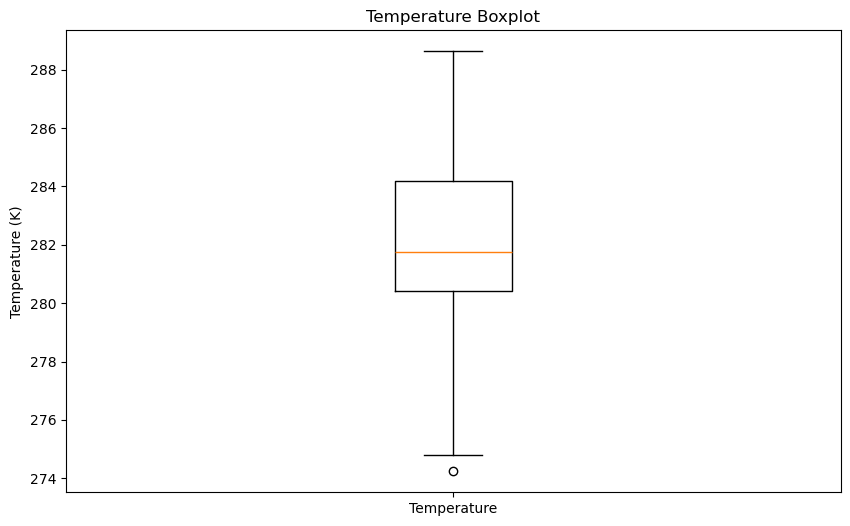

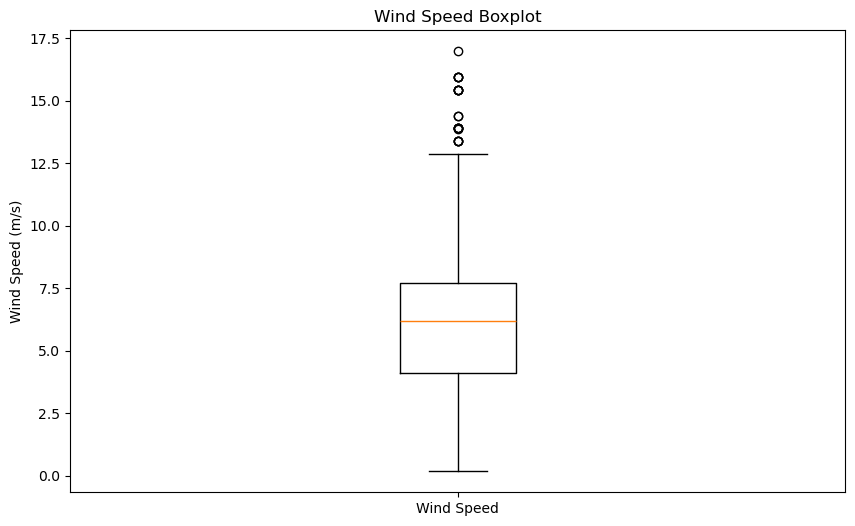

In [63]:
# Box diagram of temperature
plt.figure(figsize=(10, 6))
plt.boxplot(df_weather_filtered['temperature'].dropna())
plt.title('Temperature Boxplot')
plt.ylabel('Temperature (K)')
plt.xticks([1], ['Temperature'])
plt.show()

# Box diagram of windSpeed
plt.figure(figsize=(10, 6))
plt.boxplot(df_weather_filtered['wind_speed'].dropna())
plt.title('Wind Speed Boxplot')
plt.ylabel('Wind Speed (m/s)')
plt.xticks([1], ['Wind Speed'])
plt.show()


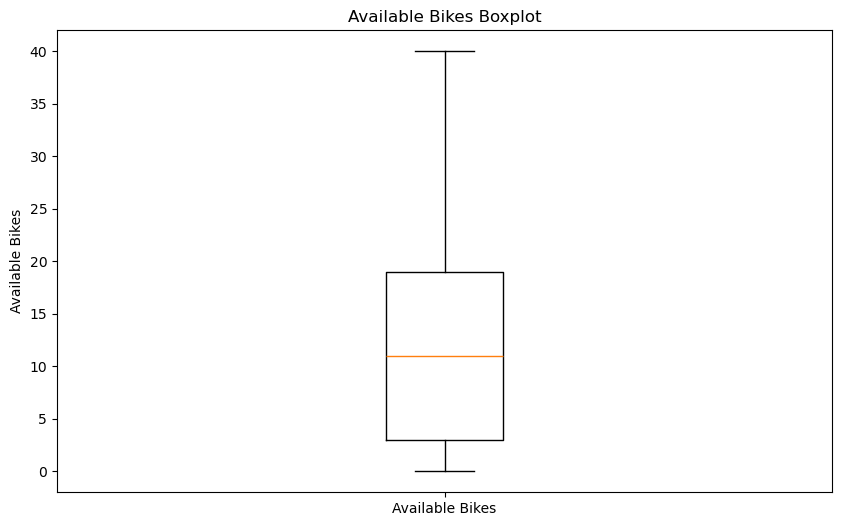

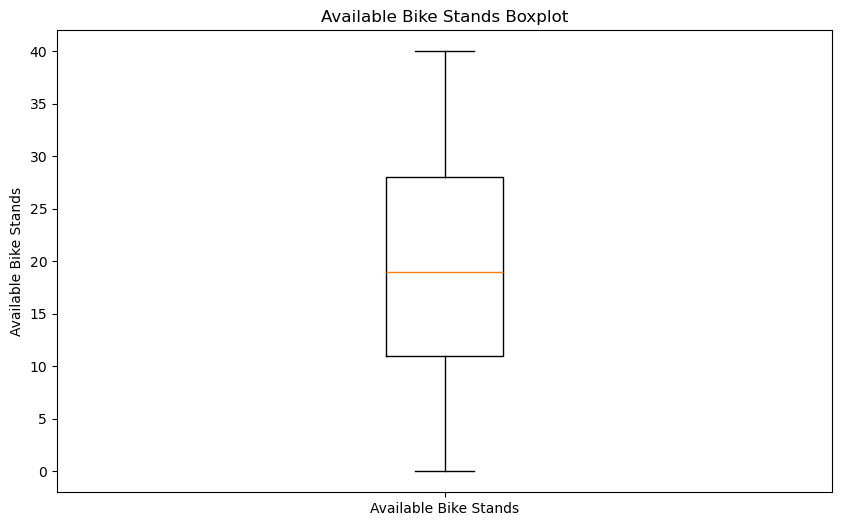

In [64]:
# The box diagram of the bicycle is available
plt.figure(figsize=(10, 6))
plt.boxplot(df_availability_filtered['available_bikes'].dropna())
plt.title('Available Bikes Boxplot')
plt.ylabel('Available Bikes')
plt.xticks([1], ['Available Bikes'])
plt.show()

# Box map of available parking Spaces
plt.figure(figsize=(10, 6))
plt.boxplot(df_availability_filtered['available_bike_stands'].dropna())
plt.title('Available Bike Stands Boxplot')
plt.ylabel('Available Bike Stands')
plt.xticks([1], ['Available Bike Stands'])
plt.show()


All good!!!! 

In order to more accurately match weather conditions, the weather data is temporally interpolated to create a denser time series dataset. Next, the interpolated weather data was combined with the bike availability data by last_update and number (station number). In this way, each bike data point will have a corresponding weather condition.况。

In [65]:
# Defines a list of category type columns
category_columns = ['weather_main', 'weather_description']

# Make sure the 'last_update' column is part of the DataFrame
if 'last_update' not in df_weather_filtered.columns:
    df_weather_filtered = df_weather_filtered.reset_index()

# Convert 'last_update' to the datetime type, where.loc is used to avoid SettingWithCopyWarning
df_weather_filtered.loc[:, 'last_update'] = pd.to_datetime(df_weather_filtered.loc[:, 'last_update'])

# Select numeric columns for interpolation
df_weather_numerical = df_weather_filtered.set_index('last_update')[weather_numerical_columns]
df_weather_interpolated = df_weather_numerical.interpolate(method='time').reset_index()

# Use.ffill() directly for forward fill to avoid FutureWarning
df_weather_filtered.loc[:, category_columns] = df_weather_filtered.loc[:, category_columns].ffill()

# Merge the categorical data back into the interpolated numerical data
df_weather_final = pd.merge(df_weather_interpolated, df_weather_filtered.loc[:, ['last_update'] + category_columns].drop_duplicates(), on='last_update', how='left')

# show the result to check
print(df_weather_final.head())


          last_update  temperature  feels_like  pressure  humidity  \
0 2024-02-28 00:26:21       278.85      276.10    1018.0      80.0   
1 2024-02-28 00:55:00       278.87      276.13    1018.0      80.0   
2 2024-02-28 01:27:46       278.97      276.58    1018.0      80.0   
3 2024-02-28 01:58:16       279.26      276.93    1017.0      80.0   
4 2024-02-28 02:27:23       279.29      276.64    1017.0      80.0   

   visibility  wind_speed  wind_deg  clouds_all weather_main  \
0     10000.0        3.60     210.0        40.0       Clouds   
1     10000.0        3.60     210.0        40.0       Clouds   
2     10000.0        3.09     200.0        40.0       Clouds   
3     10000.0        3.09     200.0        75.0         Rain   
4     10000.0        3.60     210.0        75.0         Rain   

  weather_description  
0    scattered clouds  
1    scattered clouds  
2    scattered clouds  
3          light rain  
4          light rain  


In [66]:
# Sort the two Dataframes by last_update
df_availability_sorted = df_availability_filtered.sort_values('last_update')
df_weather_sorted = df_weather_final.sort_values('last_update')

# Use merge_asof to find the most recent time record to merge
# We use nearest, so that the nearest can be found regardless of whether the timestamp is first or last
df_combined = pd.merge_asof(df_availability_sorted, df_weather_sorted,
                            on='last_update', direction='nearest')

print(df_combined.head())


   number  available_bikes  available_bike_stands         last_update  \
0      13                0                     30 2024-02-28 00:00:00   
1      59                7                     13 2024-02-28 00:00:02   
2     103                8                     32 2024-02-28 00:00:02   
3      73                7                     23 2024-02-28 00:00:06   
4      22               10                     10 2024-02-28 00:00:07   

   temperature  feels_like  pressure  humidity  visibility  wind_speed  \
0       278.85       276.1    1018.0      80.0     10000.0         3.6   
1       278.85       276.1    1018.0      80.0     10000.0         3.6   
2       278.85       276.1    1018.0      80.0     10000.0         3.6   
3       278.85       276.1    1018.0      80.0     10000.0         3.6   
4       278.85       276.1    1018.0      80.0     10000.0         3.6   

   wind_deg  clouds_all weather_main weather_description  
0     210.0        40.0       Clouds    scattered clouds 

In [67]:
# Print 5 random rows of data for verification
print(df_combined.sample(5))

        number  available_bikes  available_bike_stands         last_update  \
471797      76               17                     21 2024-03-22 11:50:26   
737878      16               11                      9 2024-04-04 17:41:50   
348382      48                6                     34 2024-03-16 08:40:27   
385029     101               28                      2 2024-03-18 06:27:12   
470817     107                2                     38 2024-03-22 10:41:08   

        temperature  feels_like  pressure  humidity  visibility  wind_speed  \
471797       283.74      282.34    1018.0      57.0     10000.0       10.29   
737878       282.62      280.02     997.0      89.0      8000.0        5.14   
348382       281.12      278.87    1014.0      89.0     10000.0        3.60   
385029       281.04      278.26    1009.0      87.0     10000.0        4.63   
470817       282.27      278.36    1019.0      66.0     10000.0        9.26   

        wind_deg  clouds_all weather_main           weat

In [68]:
print(df_combined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776312 entries, 0 to 776311
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   number                 776312 non-null  int64         
 1   available_bikes        776312 non-null  int64         
 2   available_bike_stands  776312 non-null  int64         
 3   last_update            776312 non-null  datetime64[ns]
 4   temperature            776312 non-null  float64       
 5   feels_like             776312 non-null  float64       
 6   pressure               776312 non-null  float64       
 7   humidity               776312 non-null  float64       
 8   visibility             776312 non-null  float64       
 9   wind_speed             776312 non-null  float64       
 10  wind_deg               776312 non-null  float64       
 11  clouds_all             776312 non-null  float64       
 12  weather_main           776312 non-null  obje

### EDA

E:\jupyter\envs\comp30830\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\jupyter\envs\comp30830\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


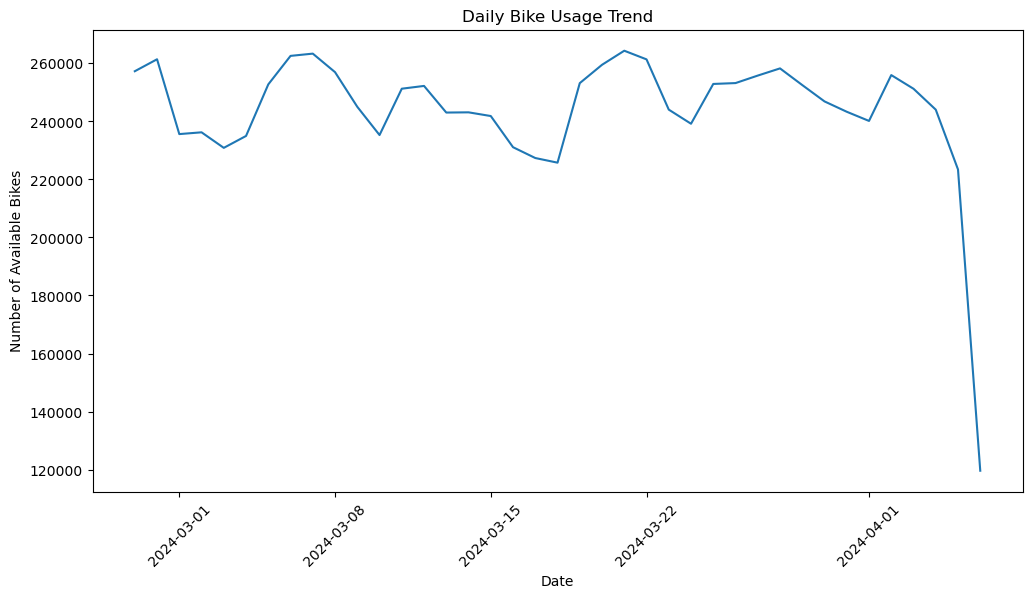

In [69]:
# Chart the trend of bicycle usage by day
df_combined['date'] = df_combined['last_update'].dt.date
daily_bikes = df_combined.groupby('date')['available_bikes'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='available_bikes', data=daily_bikes)
plt.title('Daily Bike Usage Trend')
plt.xlabel('Date')
plt.ylabel('Number of Available Bikes')
plt.xticks(rotation=45)
plt.show()

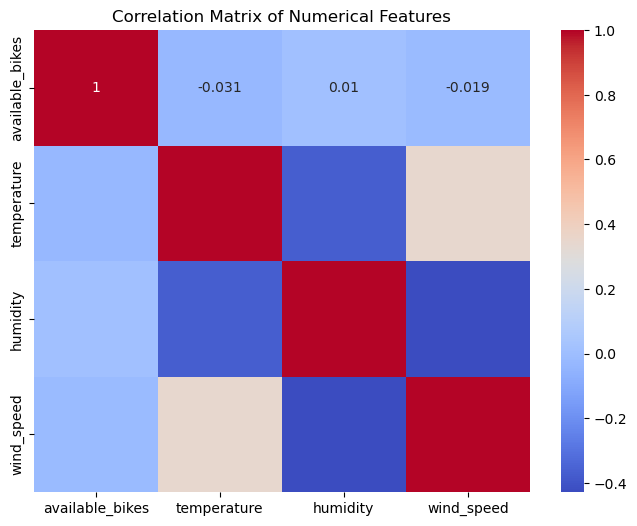

In [70]:
# Calculate correlations between numerical variables
correlation_matrix = df_combined[['available_bikes', 'temperature', 'humidity', 'wind_speed']].corr()

# Draw a correlation heat map
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


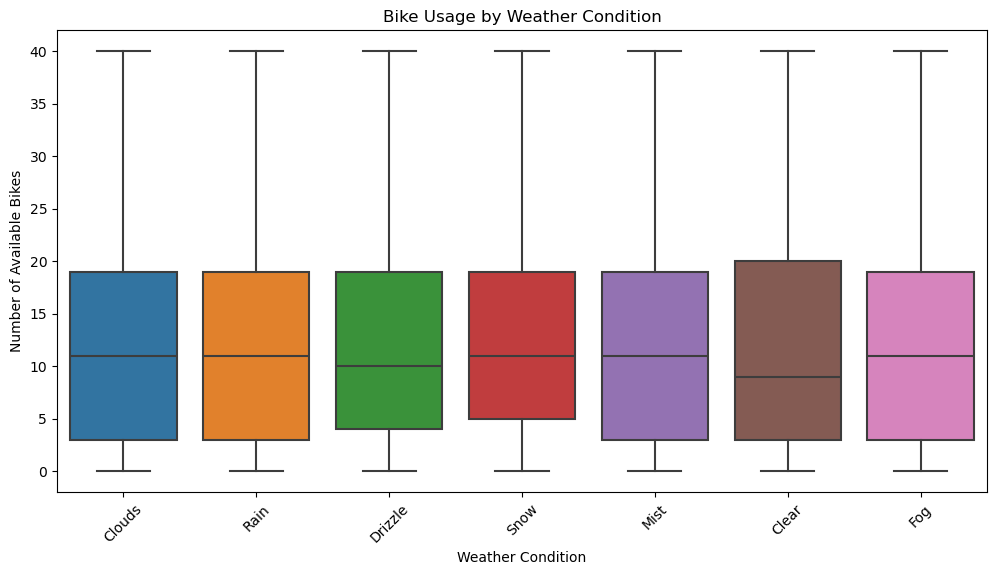

In [71]:
# Analyze bicycle usage in different weather conditions
plt.figure(figsize=(12, 6))
sns.boxplot(x='weather_main', y='available_bikes', data=df_combined)
plt.title('Bike Usage by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Available Bikes')
plt.xticks(rotation=45)
plt.show()


Temperature and bike usage

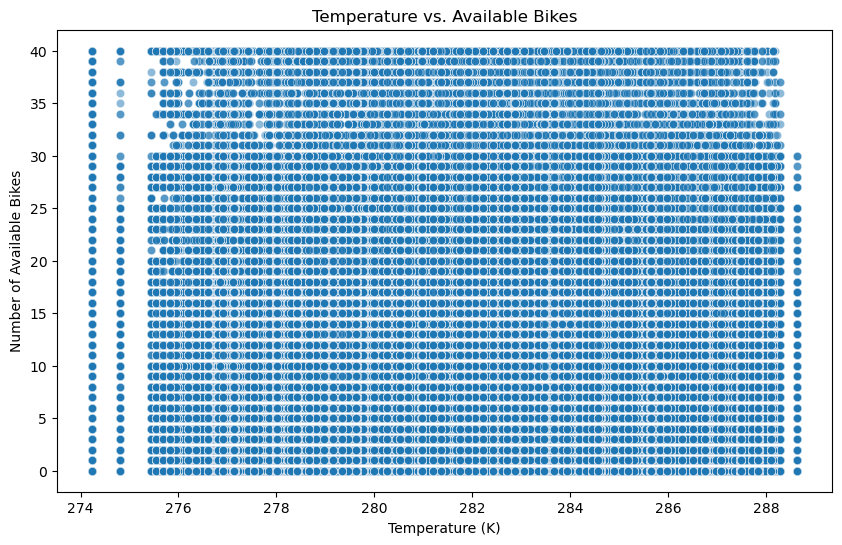

In [72]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temperature', y='available_bikes', data=df_combined, alpha=0.5)
plt.title('Temperature vs. Available Bikes')
plt.xlabel('Temperature (K)')
plt.ylabel('Number of Available Bikes')
plt.show()


Humidity and bike usage

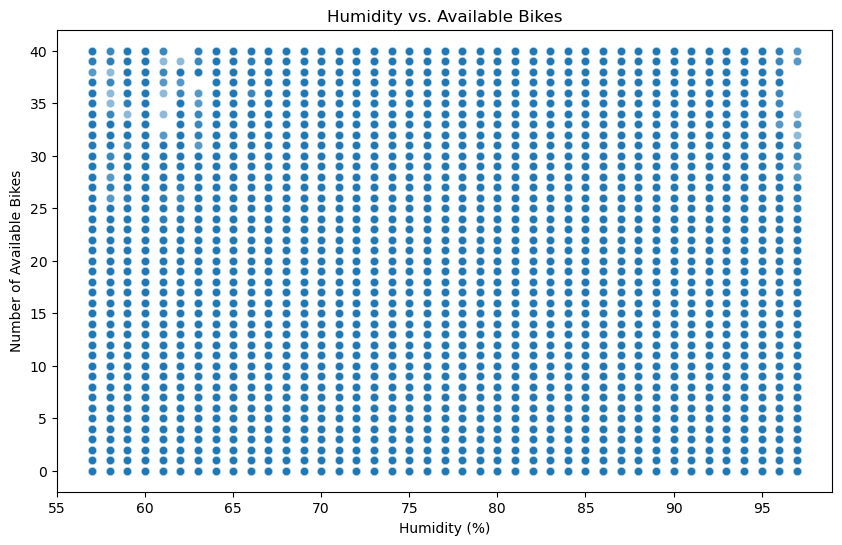

In [73]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='humidity', y='available_bikes', data=df_combined, alpha=0.5)
plt.title('Humidity vs. Available Bikes')
plt.xlabel('Humidity (%)')
plt.ylabel('Number of Available Bikes')
plt.show()


Wind speed and bicycle usage
Assess the relationship between wind speed and bicycle use to determine whether strong winds reduce bicycle use.

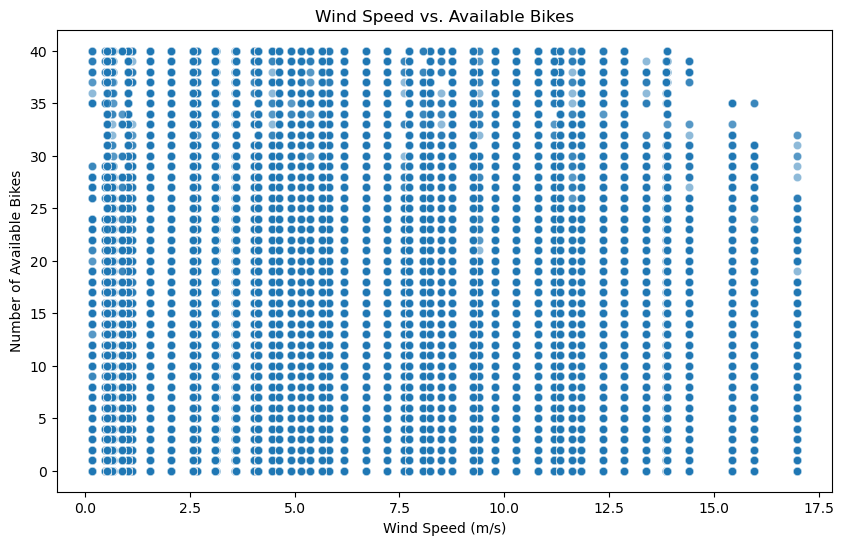

In [74]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind_speed', y='available_bikes', data=df_combined, alpha=0.5)
plt.title('Wind Speed vs. Available Bikes')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Number of Available Bikes')
plt.show()


Cloud cover and bicycle usage
Explore the relationship between cloud cover and bike usage to see how people tend to use their bikes on cloudy or sunny days.

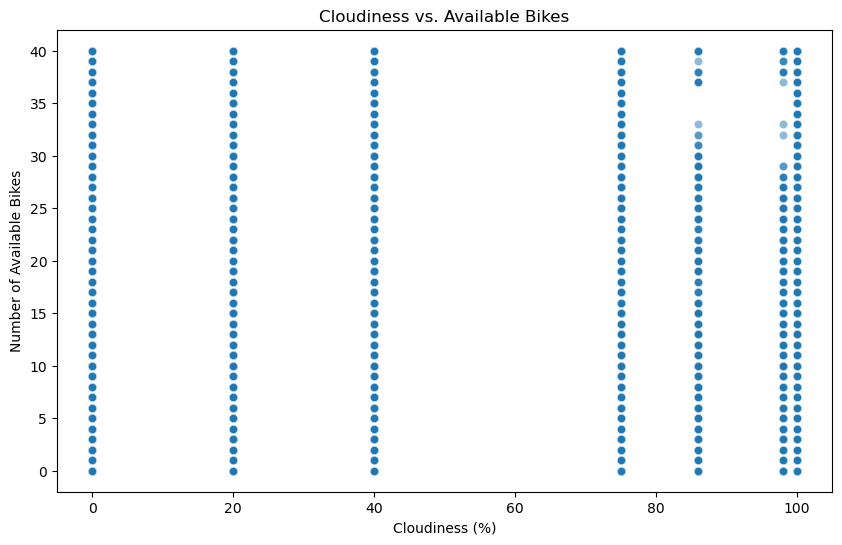

In [75]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='clouds_all', y='available_bikes', data=df_combined, alpha=0.5)
plt.title('Cloudiness vs. Available Bikes')
plt.xlabel('Cloudiness (%)')
plt.ylabel('Number of Available Bikes')
plt.show()


### Feature engineering

In [76]:
# Extract the time feature from the last_update
df_combined['hour'] = df_combined['last_update'].dt.hour
df_combined['day_of_week'] = df_combined['last_update'].dt.dayofweek
df_combined['is_weekend'] = df_combined['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df_combined['is_peak_hour'] = df_combined['hour'].apply(lambda x: 1 if 7 <= x <= 9 or 16 <= x <= 18 else 0)


In [77]:
# Create a "feels_like_temp" feature
df_combined['feels_like_temp'] = df_combined['temperature'] - ((100 - df_combined['humidity']) / 5)


### Model and Prediction

In [78]:
# Prepare feature X and target variable y, making sure that is_weekend is not included
X = df_combined.drop(['number', 'available_bikes', 'last_update', 'weather_main', 'weather_description', 'is_weekend'], axis=1, errors='ignore')
y = df_combined['available_bikes']

In [79]:
# Removes the 'date' column from the feature set
X = df_combined.drop(['number', 'available_bikes', 'last_update', 'weather_main', 'weather_description', 'date'], axis=1, errors='ignore')
y = df_combined['available_bikes']


# Re-split the data set into the training set and the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [37]:
# Initialization model
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting Trees": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train the model and evaluate it
results = []
for name, model in models.items():
    model.fit(X_train, y_train)  # train the models
    y_pred = model.predict(X_test)  # do prediction
    
    mse = mean_squared_error(y_test, y_pred)  # Calculate the mean square error
    rmse = mse ** 0.5  # Calculate root-mean-square error
    r2 = r2_score(y_test, y_pred)  # Calculate the R² fraction
    
    results.append((name, rmse, r2))
    print(f"{name} - RMSE: {rmse:.2f}, R2: {r2:.2f}")


Linear Regression - RMSE: 6.58, R2: 0.56
Decision Tree - RMSE: 6.26, R2: 0.61
Random Forest - RMSE: 6.19, R2: 0.61
Gradient Boosting Trees - RMSE: 6.24, R2: 0.61


1. The linear regression model provided baseline performance with RMSE of 6.58 and R² of 0.56.
2. 
The decision tree regression model has improved in performance, with RMSE down to 6.26 and R² 0.61
3. 
Random forest regression further improved the prediction accuracy, reaching RMSE of 6.19 and R² maintaining 0.61, showing the best performance of all model
4. .
Gradient lift trees perform similarly to decision trees and random forests, with RMSE of 6.24 and R² of 0.
5. 1.
Model selection and next step
Random forests showed the best performance, although not far behind decision trees and gradient lift trees. However, the advantage of decision trees is that they can better handle the interactions and nonlinear relationships between features, while reducing the risk of overfitting, resulting in better RMSE results on the dataset.
The decision tree is selected as the model to start the prediction through an initial evaluationRMSE结果。

Use test dataset to check again

In [81]:
# Initialization model
model_test = {"Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)}

# Train the model and evaluate it
result_test = []
for name, model in model_test.items():
    model.fit(X_test, y_test)  # train the models
    y_pred = model.predict(X_test)  # do prediction
    
    mse = mean_squared_error(y_test, y_pred)  # Calculate the mean square error
    rmse = mse ** 0.5  # Calculate root-mean-square error
    r2 = r2_score(y_test, y_pred)  # Calculate the R² fraction
    
    results.append((name, rmse, r2))
    print(f"{name} - RMSE: {rmse:.2f}, R2: {r2:.2f}")

Random Forest - RMSE: 4.54, R2: 0.79


Compare data from the training set and the test set
Using random forest model is a reasonable choice.
Low RMSE and high R² indices on the test set indicate that the model has good generalization ability and can make accurate predictions on unseen data. This means that the model did not overfit during training and was able to capture key patterns in the data well.

The benefits of choosing a random forest model include:
1. Strong generalization ability: Random forests improve generalization ability and reduce the risk of overfitting by constructing multiple decision trees and averaging or majority voting on their predicted results.
2. Strong processing capacity: it can process high-dimensional data, automatically select features, and is insensitive to missing data, and is suitable for various data types.
3. Explanatory: While the random forest model is less explanatory than a single decision tree, by looking at the importance of features, we can still gain insights into which features have the greatest impact on the predicted outcome.步提升模型表现

In [82]:
# feature
X = df_combined.drop(['available_bikes', 'available_bike_stands'], axis=1)
# Make sure X does not contain any non-numeric columns
X = X.select_dtypes(include=[np.number])

# Target variable 1: Number of free bikes
y_bikes = df_combined['available_bikes']

# Target variable 2: Number of free stands
y_stands = df_combined['available_bike_stands']



# Training set and evaluation set for the number of free bikes
X_train_bikes, X_eval_bikes, y_train_bikes, y_eval_bikes = train_test_split(X, y_bikes, test_size=0.2, random_state=42)

# Training set and evaluation set for the number of free stands
X_train_stands, X_eval_stands, y_train_stands, y_eval_stands = train_test_split(X, y_stands, test_size=0.2, random_state=42)


In [84]:
# Random forest model for predicting the number of free bikes
rf_bikes = RandomForestRegressor(n_estimators=100, random_state=42)
rf_bikes.fit(X_train_bikes, y_train_bikes)
y_pred_bikes_rf = rf_bikes.predict(X_eval_bikes)
rmse_bikes_rf = mean_squared_error(y_eval_bikes, y_pred_bikes_rf, squared=False)

# Decision tree model for predicting the number of free stands
rf_stands = RandomForestRegressor(n_estimators=100, random_state=42)
rf_stands.fit(X_train_stands, y_train_stands)
y_pred_stands_rf = rf_stands.predict(X_eval_stands)
rmse_stands_rf = mean_squared_error(y_eval_stands, y_pred_stands_rf, squared=False)

print(f"RMSE for available bikes prediction with RandomForest: {rmse_bikes_rf:.2f}")
print(f"RMSE for available bike stands prediction with RandomForest: {rmse_stands_rf:.2f}")


RMSE for available bikes prediction with RandomForest: 1.33
RMSE for available bike stands prediction with RandomForest: 1.34


In [85]:
# Save an free bike prediction model
with open('rf_bikes_model.pickle', 'wb') as f:
    pickle.dump(rf_bikes, f)

# Save an free stands prediction model
with open('rf_stands_model.pickle', 'wb') as f:
    pickle.dump(rf_stands, f)
